Initial train image count: 1728
Initial valid image count: 439
Checking 1728 images in train for corruption...
Final training image count: 1728
Checking 439 images in valid for corruption...
Final validing image count: 439
Classes: ['closedFist', 'fingerCircle', 'fingerSymbols', 'multiFingerBend', 'openPalm', 'semiOpenFist', 'singleFingerBend', 'symbolFour', 'symbolOne', 'symbolThree', 'symbolTwo']
Number of classes: 11


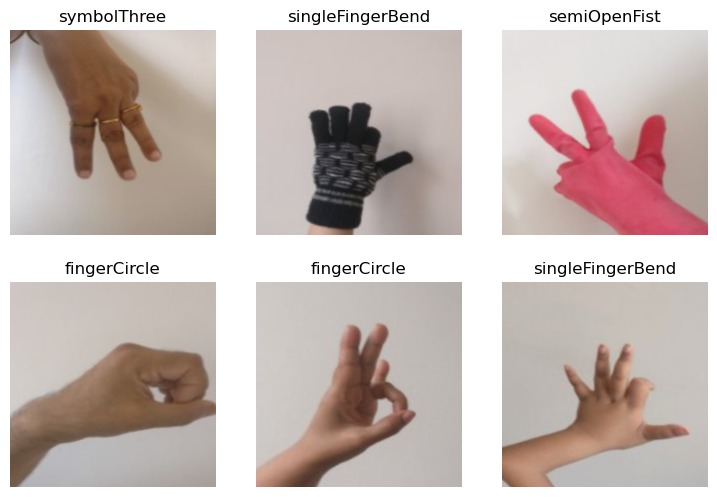

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import mediapipe as mp
from fastai.vision.all import *
from PIL import Image
from fastai.vision.utils import show_image
from torchvision.models import densenet121
from pathlib import Path


# Clear any cached GPU memory
torch.cuda.empty_cache()

# Remove corrupt images
def clean_images(img_paths):
    for img_path in img_paths:
        try:
            img = PILImage.create(img_path)
            tensor = ToTensor()(img)
            if not torch.isfinite(tensor).all():
                print(f"Bad tensor: {img_path}")
                img_path.unlink()
        except Exception as e:
            print(f"Corrupt image: {img_path}, Error: {e}")
            img_path.unlink()


path = Path('data')

print("Initial train image count:", len(get_image_files(path/'train')))
print("Initial valid image count:", len(get_image_files(path/'valid')))

# Clean up images in train and valid folders
for split in ['train', 'valid']:
    imgs = get_image_files(path/split)
    print(f"Checking {len(imgs)} images in {split} for corruption...")
    clean_images(imgs)
    print(f"Final {split}ing image count:", len(get_image_files(path/split)))

# Create DataLoaders from folders
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[Resize(224, method='squish')],
    batch_tfms=aug_transforms(
        mult=1.0,
        do_flip=True,
        flip_vert=False,
        max_rotate=20.0,
        max_zoom=1.2,
        max_lighting=0.2,
        max_warp=0.2,
        p_affine=0.75,
        p_lighting=0.75
    )
)
dls = dblock.dataloaders(path, bs=32)

print("Classes:", dls.vocab)
print("Number of classes:", dls.c)

# Show batch
dls.show_batch(max_n=6)
plt.show()

SuggestedLRs(valley=0.0012022644514217973)

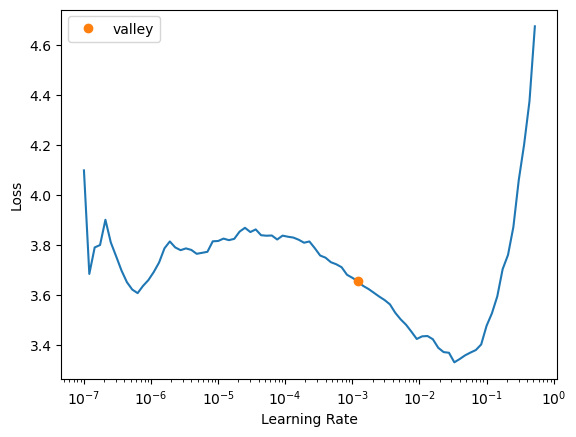

In [16]:
# Create the learner with DenseNet121
learn = vision_learner(
    dls,
    densenet121,
    metrics=error_rate,
    pretrained=True
)

learn.to_fp32().to('cuda')

# Suggest learning rate
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time
0,3.115653,1.780048,0.615034,00:44


Better model found at epoch 0 with error_rate value: 0.6150341629981995.


epoch,train_loss,valid_loss,error_rate,time
0,2.084019,1.376700,0.455581,00:47
1,1.803634,1.189633,0.389522,00:46
2,1.481588,0.985994,0.330296,00:46
3,1.205872,0.884494,0.287016,00:48
4,0.971243,0.789566,0.243736,00:48
5,0.784807,0.734384,0.241458,00:48
6,0.667518,0.676549,0.236902,00:48
7,0.545544,0.663700,0.200456,00:31
8,0.473414,0.655938,0.209567,00:20
9,0.472170,0.651998,0.207289,00:19


Better model found at epoch 0 with error_rate value: 0.45558086037635803.
Better model found at epoch 1 with error_rate value: 0.38952162861824036.
Better model found at epoch 2 with error_rate value: 0.330296128988266.
Better model found at epoch 3 with error_rate value: 0.2870159447193146.
Better model found at epoch 4 with error_rate value: 0.24373576045036316.
Better model found at epoch 5 with error_rate value: 0.24145786464214325.
Better model found at epoch 6 with error_rate value: 0.23690204322338104.
Better model found at epoch 7 with error_rate value: 0.20045557618141174.


SuggestedLRs(valley=1.4454397387453355e-05)

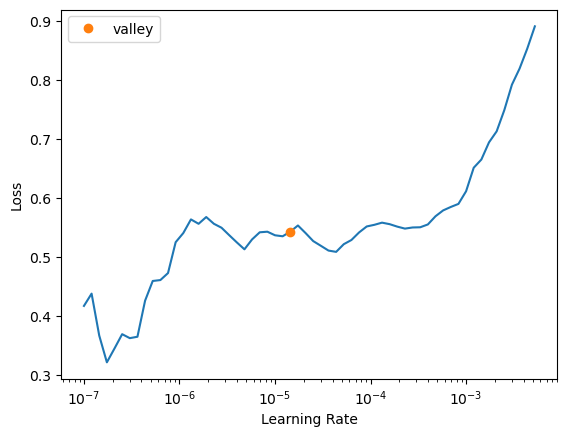

In [17]:
# Train the head with frozen base
learn.fine_tune(
    10,
    base_lr=1e-3,
    cbs=SaveModelCallback(monitor='error_rate', fname='best-densenet')
)

# Unfreeze and fine-tune the whole model with discriminative learning rates
learn.unfreeze()
learn.lr_find()

In [18]:
# Use a range of learning rates for different layers
learn.fit_one_cycle(
    10,
    lr_max=slice(1e-6, 1e-4),
    cbs=SaveModelCallback(monitor='error_rate', fname='best-densenet-finetuned')
)

epoch,train_loss,valid_loss,error_rate,time
0,0.455793,0.659857,0.211845,00:19
1,0.464781,0.656508,0.207289,00:19
2,0.486370,0.653831,0.209567,00:19
3,0.478938,0.617692,0.198178,00:19
4,0.420793,0.615594,0.191344,00:19
5,0.387196,0.613402,0.193622,00:19
6,0.361433,0.623435,0.191344,00:20
7,0.356507,0.608853,0.186788,00:19
8,0.338852,0.609481,0.189066,00:19
9,0.333617,0.611075,0.179954,00:19


Better model found at epoch 0 with error_rate value: 0.21184509992599487.
Better model found at epoch 1 with error_rate value: 0.20728929340839386.
Better model found at epoch 3 with error_rate value: 0.19817768037319183.
Better model found at epoch 4 with error_rate value: 0.19134396314620972.
Better model found at epoch 7 with error_rate value: 0.1867881566286087.
Better model found at epoch 9 with error_rate value: 0.1799544394016266.


Image mode: RGB


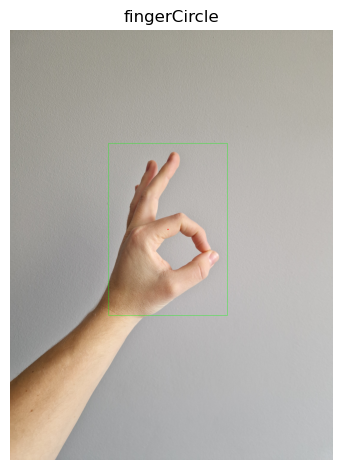

Center of hand: (1467, 1854)
Confidence: 0.8841
Image mode: RGB


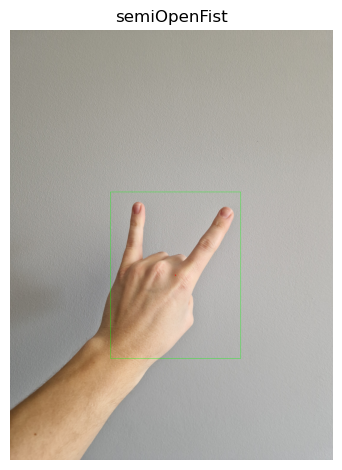

Center of hand: (1537, 2280)
Confidence: 0.8471
Image mode: RGB


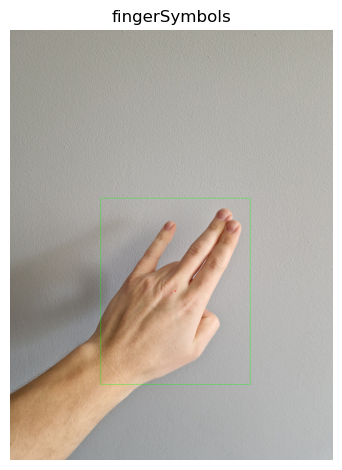

Center of hand: (1536, 2429)
Confidence: 0.9261


In [ ]:
for test_img_path in ['20250406_135604.jpg', '20250406_135614.jpg', '20250406_135846.jpg']:
    test_img_path_full = f"do_rozpoznania/{test_img_path}"
    test_img = PILImage.create(test_img_path_full)

    # Read the image using OpenCV
    img = cv2.imread(test_img_path_full)  # BGR format
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    h, w, _ = img.shape

    # Resize the test image to match the model input size
    resize = Resize(224, method='squish')
    resized_img = resize(test_img)

    # Predict the label for the image
    pred_label, _, probs = learn.predict(PILImage.create(resized_img))


    mp_hands = mp.solutions.hands.Hands(
        static_image_mode=True,
        max_num_hands=1,
        min_detection_confidence=0.5
    )

    results = mp_hands.process(img_rgb)


    if results.multi_hand_landmarks:
        hand_landmarks = results.multi_hand_landmarks[0].landmark

        # Get all landmark coordinates (scaled to image size)
        xs = [int(lm.x * w) for lm in hand_landmarks]
        ys = [int(lm.y * h) for lm in hand_landmarks]

        # Calculate bounding box corners
        x1, x2 = min(xs), max(xs)
        y1, y2 = min(ys), max(ys)

        # Expand box a bit (optional)
        margin = int(0.1 * max(x2 - x1, y2 - y1))
        x1, y1 = max(0, x1 - margin), max(0, y1 - margin)
        x2, y2 = min(w, x2 + margin), min(h, y2 + margin)

        # Draw bounding box around the hand
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Calculate and draw center
        cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
        cv2.circle(img, (cx, cy), 5, (0, 0, 255), -1)

        # Show the image
        plt.close('all')
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(pred_label)
        plt.tight_layout()
        plt.show()

        print(f"Center of hand: ({cx}, {cy})")
    else:
        print("No hand detected.")

    print(f"Confidence: {probs.max():.4f}")

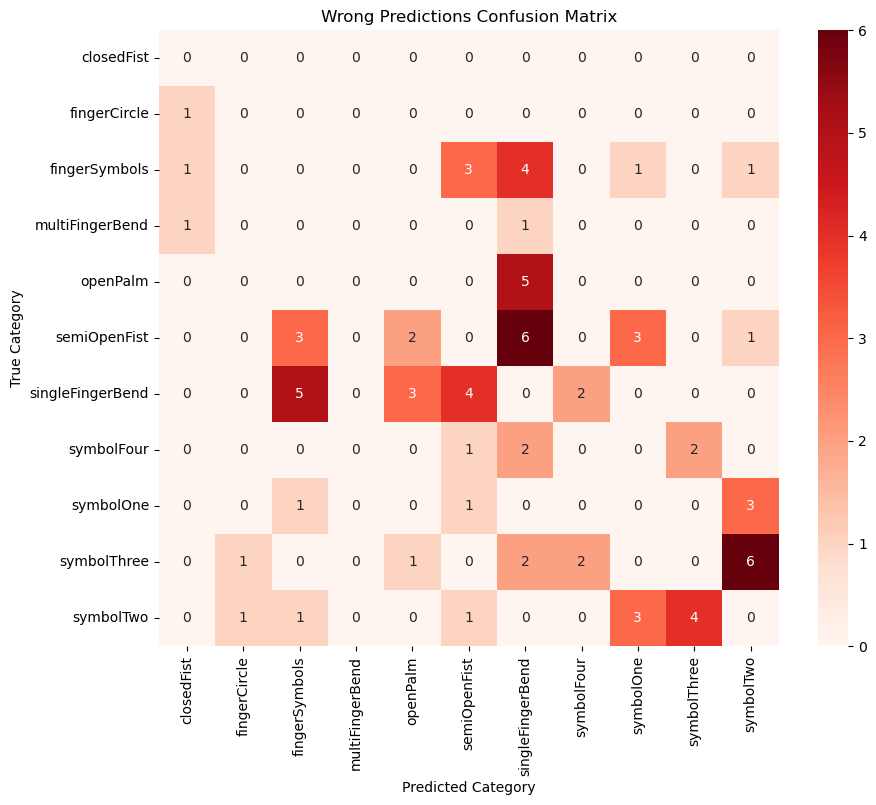

In [20]:
wrong_dir = Path('data/wrong_predicts')
wrong_dir.mkdir(exist_ok=True)

# Clear wrong_predicts directory
for f in wrong_dir.iterdir():
    if f.is_file():
        f.unlink()

class_names = dls.vocab
wrong_conf_matrix = pd.DataFrame(0, index=class_names, columns=class_names)

# Save wrong predictions
for img_path in imgs:
    img = PILImage.create(img_path)
    pred_label, _, probs = learn.predict(img)
    true_label = img_path.parent.name
    if str(pred_label) != true_label:
        save_name = f"{pred_label}_{true_label}_{img_path.name}"
        img.save(wrong_dir / save_name)
        wrong_conf_matrix.loc[true_label, str(pred_label)] += 1
        

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(wrong_conf_matrix, annot=True, fmt="d", cmap="Reds")
plt.xlabel("Predicted Category")
plt.ylabel("True Category")
plt.title("Wrong Predictions Confusion Matrix")
plt.show()